In [1]:
# Import libraries
import shapefile as sf
import numpy as np
import sys
import geopandas as gpd
import pandas as pd
import adumanis

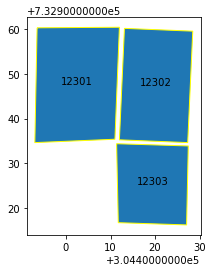

In [2]:
# ShapefileDir = "data/Data Dummy Pengukuran Persil Tanah.shp"
ShapefileDir = "data/coba3persilatasbawah.shp"
# ShapefileDir = "data2/DataDummyAduManis1.shp"
# ShapefileDir = "output/DataPersilTanahCleaned7.shp"


fileName = ShapefileDir.split("/")[-1][0:-4]
df = gpd.read_file(ShapefileDir)
ax = df.plot(edgecolor="yellow")
df.apply(lambda x: ax.annotate(text=x['NIB'], xy=x.geometry.centroid.coords[0], ha='center'), axis =1);

In [3]:
numPersilControl = int(input('Jumlah persil sebagai kontrol:'))
nibcontrol =[]
for i in range(numPersilControl):
    nibcontrol.append(input('Nomor Induk Bidang :'))
    
input('Apakah Perataan Blok ini akan menggunakan bobot ? (y/t):')
   
tolerance = float(input('Nilai Toleransi Residu Titik Batas:'))


#This if for bypass only.
# nibcontrol=[]
# nibcontrol.append("12301")
# nibcontrol.append("12303")
# nibcontrol.append("12310")
# tolerance = 2

Jumlah persil sebagai kontrol: 2
Nomor Induk Bidang : 12301
Nomor Induk Bidang : 12302
Apakah Perataan Blok ini akan menggunakan bobot ? (y/t): y
Nilai Toleransi Residu Titik Batas: 3


In [4]:
# READ FILE INPUT
ShapeFile = sf.Reader(ShapefileDir)
Fields = ShapeFile.fields
Shapes = ShapeFile.shapes()
Records = ShapeFile.records()

NIBIndex = adumanis.findNIBIndex(Fields)

In [5]:
#SETUP First Point to create small coordinate
# Minimize big value of each point, make it easier to calculate
# with average of all first shape

X = Y = 0
for i in range (1, len(Shapes[0].points)):
    X = Shapes[0].points[i][0]+X
    Y = Shapes[0].points[i][1]+Y
X = X/i
Y = Y/i

# # Other Method
# X = Shapes[0].points[0][0]
# Y = Shapes[0].points[0][1]

In [6]:
# Parse point
dataPersils = []
numControl = 0
numObserve = 0
persilNonControl = []
numParcel = len(Shapes)
for p in range (numParcel):
    controlStatus = 0
    if(Records[p][NIBIndex] in nibcontrol):
        controlStatus = True
    else:
        controlStatus = False
        persilNonControl.append(Records[p][NIBIndex])

    point =adumanis.Points()
    dataPoint = []
    idx = 0
    for q,tempP in enumerate (Shapes[p].points):
        x = tempP[0] - X 
        y = tempP[1] - Y
        dataPoint.append([x,y,idx])
        idx = idx +1
    point.add(Records[p][NIBIndex], controlStatus, dataPoint)
    dataPersils.append(point)
    #menghitung jumlah point control
    if(controlStatus == True):
        numControl = numControl+len(Shapes[p].points)-1
    else:
        numObserve = numObserve+len(Shapes[p].points)-1

In [7]:
## TIE POINT CREATOR
tieGroups = []
tieGroups.clear()
for persilI in range (len(dataPersils)):
    lengthI = len(dataPersils[persilI].points) -1
    for pointI in range (lengthI):
        tiePoint = adumanis.TiePoints()
        NIBA = dataPersils[persilI].nib
        # indexA = dataPersils[persilI].ponits[pointI][2]
        indexA = pointI
        controlA = dataPersils[persilI].isControl
        xA = dataPersils[persilI].points[pointI][0]
        yA = dataPersils[persilI].points[pointI][1]

        for persilJ in range (persilI, len(dataPersils)):
            if(persilI != persilJ):    
                lengthJ = len(dataPersils[persilJ].points) -1
                for pointJ in range (lengthJ):
                    NIBB = dataPersils[persilJ].nib
                    indexB = pointJ
                    # indexB = dataPersils[persilJ].points[pointJ][2]
                    controlB = dataPersils[persilJ].isControl
                    xB = dataPersils[persilJ].points[pointJ][0]
                    yB = dataPersils[persilJ].points[pointJ][1]

                    a = dataPersils[persilI].points[pointI][:2]
                    b = dataPersils[persilJ].points[pointJ][:2]
                    dist = adumanis.Euclidean(a,b)
                    if(dist <= tolerance):
                        oldGroup = False
                        for (n, eachGroup) in enumerate (tieGroups):
                            if (eachGroup.isGrouped(NIBA, indexA)):
                                oldGroup = True
                                if (not eachGroup.isGrouped(NIBB, indexB)):
                                    tieGroups[n].add(NIBB, indexB, controlB, xB, yB)
                            elif (eachGroup.isGrouped(NIBB, indexB)):
                                oldGroup = True
                                if (not eachGroup.isGrouped(NIBA, indexA)):
                                    tieGroups[n].add(NIBA, indexA, controlA, xA, yA)

                        if(not oldGroup):
                            if not tiePoint.isGrouped(NIBA, indexA):
                                tiePoint.add(NIBA, indexA, controlA, xA, yA)
                            tiePoint.add(NIBB, indexB, controlB, xB, yB)
        
        if (tiePoint.length() > 0):
            tieGroups.append(tiePoint)
        
        alone = True
        for (n, eachGroup) in enumerate (tieGroups):
            if (eachGroup.isGrouped(NIBA, indexA)):
                alone = False
        
        if (alone):
            alonePoint = adumanis.TiePoints()
            alonePoint.add(NIBA, indexA, controlA, xA, yA)
            tieGroups.append(alonePoint)


In [8]:
## PARAMTER CHECKING
numFreeTiePoint = 0
for (n, eachGroup) in enumerate (tieGroups):
    if (not eachGroup.isContainControl()):
        numFreeTiePoint = numFreeTiePoint+1

paramFreeTiePoint = numFreeTiePoint*2
paramPointNonControl = numObserve *2
paramPersilNonControl = (numParcel-len(nibcontrol)) * 4

# Cek apakah observer lebih banyak dari parameter
numParams = paramPersilNonControl + paramFreeTiePoint

# Its still confuse (please find away to fix it
numObs = paramPointNonControl
if numParams > numObs:
    print ("Tidak bisa dilanjutkan, parameter lebih banyak dari titik yang diobservasi")
    sys.exit(0)


In [9]:
## CREATE MATRIX
matrixA = np.zeros((numObs,numParams))
matrixF = np.zeros((numObs,1))

row = -1
col = -1
colPersilStart = paramFreeTiePoint

for (i, tie) in enumerate (tieGroups):
    tieWithControl = tie.isContainControl()
    if (not tieWithControl):
        col = col+1
    for j in range (tie.length()):
        if(not tie.control[j]):
            row = row + 1
            
            idxPersil = persilNonControl.index(str(tie.nib[j]))
            matrixA[2*row , colPersilStart + 4*idxPersil] = tie.x[j]  
            matrixA[2*row , colPersilStart + 4*idxPersil + 1] = tie.y[j] * -1 
            matrixA[2*row , colPersilStart + 4*idxPersil + 2] = 1
            matrixA[2*row , colPersilStart + 4*idxPersil + 3] = 0 

            matrixA[2*row+1 , colPersilStart + 4*idxPersil] = tie.y[j]  
            matrixA[2*row+1 , colPersilStart + 4*idxPersil + 1] = tie.x[j] 
            matrixA[2*row+1 , colPersilStart + 4*idxPersil + 2] = 0
            matrixA[2*row+1 , colPersilStart + 4*idxPersil + 3] = 1 

            if(tieWithControl):
                #Bentuk matrixF
                # [x, y] = tie.controlPoint()
                [x, y] = tie.closestControl(tie.x[j],tie.y[j])
                matrixF[2*row,0] = x
                matrixF[2*row+1,0] = y
            else:
                # isikan yang -1 dan -1 di awal
                matrixA[2*row, 2*col] = -1
                matrixA[2*row+1, 2*col+1]  = -1
        

# EXPORT MATRIX TO EXCEL
da = pd.DataFrame(matrixA)
df = pd.DataFrame(matrixF)
da.to_excel(excel_writer = "outMatrix/"+fileName+"A.xlsx")
df.to_excel(excel_writer = "outMatrix/"+fileName+"F.xlsx")

In [10]:
#SOLVE THE MATRIX CALCULATION
At = np.transpose(matrixA)
AtA = np.mat(At) * np.mat(matrixA)
AtF = np.mat(At) * np.mat(matrixF)

sol = np.linalg.solve(AtA, AtF)

In [11]:
#CREATE THE NEW POINT
#REVERSE POINT TO NIB
dtype = [('nib', np.unicode_, 16), ('index', int), ('x', float),('y',float)]
finalPoint = []
idx = -1
for (i, tie) in enumerate (tieGroups):
    tieWithControl = tie.isContainControl()
    if not tieWithControl:
        idx = idx+1
    for j in range (tie.length()):
        if tieWithControl:
            
            # update the current point
            # for every group
            
            # #FLAVOUR 1
            # get the control point
            # newX, newY= tie.controlPoint()
            # newPoint = (tie.nib[j], tie.index[j], newX+X, newY+Y)
            
            # #FLAVOUR 2
            # get the control point
            # newX, newY= tie.controlPoint()
            # if (tie.control[j]):
            #     newPoint = (tie.nib[j], tie.index[j], tie.x[j]+X, tie.y[j]+Y)
            # else:
            #     newPoint = (tie.nib[j], tie.index[j], newX+X, newY+Y)
            
            # #FLAVOUR 3
            # get the control point
            # newX, newY= tie.controlPoint()
            # newPoint = (tie.nib[j], tie.index[j], tie.x[j], tie.y[j])
            
            # #FLAVOUR 4
            # find the closest point
            newX, newY= tie.closestControl(tie.x[j], tie.y[j])
            if (tie.control[j]):
                newPoint = (tie.nib[j], tie.index[j], tie.x[j]+X, tie.y[j]+Y)
            else:
                newPoint = (tie.nib[j], tie.index[j], newX+X, newY+Y)
            
        else:
            # take the result from solution
            # for coordinate x and y
            newPoint = (tie.nib[j], tie.index[j], sol[2*idx]+X, sol[2*idx+1]+Y)
        
        finalPoint.append(newPoint)

Process Finish!!


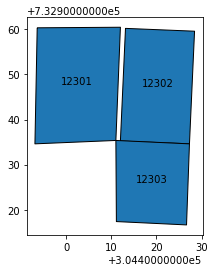

In [12]:

sortPoint = np.array(finalPoint, dtype = dtype) 
sortPoint = np.sort(sortPoint, order=['nib', 'index'])

# ## EXPORT PERSIL 
location = 'outShape/'+fileName
w = sf.Writer(location, ShapeType = 5)
w.field('NIB','C', 9)

lastNIB = 'NULL'
coordinates = []
newShapes = []
firstIndex = 0
for i in range (len(sortPoint)):
    currNIB = sortPoint[i][0]
    if (lastNIB != currNIB): 
        if len(coordinates) > 2:
            data = [sortPoint[firstIndex][2], sortPoint[firstIndex][3]]
            coordinates.append(data)
            
            if sortPoint[i][1] ==0:
                firstIndex = i
            
            
            w.record(NIB = lastNIB)
            w.poly([coordinates])
        lastNIB = currNIB
        coordinates.clear()
     
        data = [sortPoint[i][2], sortPoint[i][3]]
        coordinates.append(data)
        
    else:
        data = [sortPoint[i][2], sortPoint[i][3]]
        coordinates.append(data)

#append for the last coordinates point (the last parcel)
data = [sortPoint[firstIndex][2], sortPoint[firstIndex][3]]
coordinates.append(data)
w.record(NIB = lastNIB)
w.poly([coordinates])    
w.close()

# w.record(NIB = '12301')
# coordinates =[[304393.0350999656, 732960.358744158], [304412.2981780538, 732960.5765575996], [304411.36786695855, 732934.362762946], [304428.36828413216, 732960.0743667845], [304393.0350999656, 732960.358744158]]
# w.poly([coordinates])
# w.close

ShapeFileOut = location+'.shp'
dfout = gpd.read_file(ShapeFileOut)
ax = dfout.plot(edgecolor = "black")
dfout.apply(lambda x: ax.annotate(text=x['NIB'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
print ("Process Finish!!")